<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import r2_score

df=pd.read_excel('unisim_hist.xlsx')
# df=pd.read_excel('unisim_hist.xlsx').iloc[:, :-5]
print(df.head())

        Date  Press      Np        Gp  Wp  Winj     Press_b    Np_b  \
0 2013-05-31    332       0         0   0     0  335.219147       0   
1 2013-06-30    332       0         0   0     0  335.219147       0   
2 2013-07-31    331   61938   6858068   0     0  333.438141   61938   
3 2013-08-31    329  124403  13532213   0     0  331.746216  124403   
4 2013-09-30    328  182423  20112443   0     0  330.207275  182423   

         Gp_b  Wp_b  Winj_b  
0         0.0     0       0  
1         0.0     0       0  
2   7027100.0     0       0  
3  14113900.0     0       0  
4  20696500.0     0       0  


In [10]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 1.62E-04
cw = 4.76E-05
Swi = 0.17 ** 0.35

In [11]:
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
# df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
# df["dp"]= df["Press"].iloc[0]-df["Press"]
# df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.head()

,Date,Press,Np,Gp,Wp,Winj,Press_b,Np_b,Gp_b,Wp_b,Winj_b,t,dt
0,2013-05-31,332,0,0,0,0,335.219147,0,0.0,0,0,0.0,0.0
1,2013-06-30,332,0,0,0,0,335.219147,0,0.0,0,0,30.0,30.0
2,2013-07-31,331,61938,6858068,0,0,333.438141,61938,7027100.0,0,0,61.0,31.0
3,2013-08-31,329,124403,13532213,0,0,331.746216,124403,14113900.0,0,0,92.0,31.0
4,2013-09-30,328,182423,20112443,0,0,330.207275,182423,20696500.0,0,0,122.0,30.0


In [12]:
## PVT functions

def func_bo(p, a, b):
    bo = np.zeros(len(p))
    for i in range(len(p)):
        if p[i] < pb:
          bo[i] = a * p[i] + b
        else:
          bo[i] = bob - co * (p[i] - pb)
    return bo

def func_bg(p, a, b):
    return a*p**(b)

def func_rs(p, a, b):
    rs = np.zeros(len(p))
    for i in range(len(p)):
      if p[i] < pb:
        rs[i] = a * p[i] + b
      else:
        rs[i] = Rsi
    return rs

In [13]:
# EBM
# F/(Eo+mEg+(1+m)Efw)=N+We/(Eo+mEg+(1+m)Efw)
# We = F-N*(Eo+mEg+(1+m)Efw)

# Bt=Bo+(Rsi-Rs)*Bg
# F = Np*(Bt+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rsi-Rs)*Bg+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rp-Rs)*Bg)+(Wp-Winj)*Bw

# Eo= Bt-Bti

# Eg= Boi*(Bg/Bgi-1)

# Efw = Boi*((cf+cw.Swi)/(1-Swi))*∆p
# Efw = Boi*((cf+cw.Swi)/(1-Swi))*(pi-p)

p = df["Press"].values

bo = func_bo(p, 0.0012, 1.1538)
df["Bo"]=bo

bg = func_bg(p, 1.40676, -1.04229)
df["Bg"]=bg

rs = func_rs(p, 0.4655, 15.0114)
df["Rs"]=rs
df["Rp"] = (df["Gp"]/df["Np"]).fillna(0)

# df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]
# df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["F"] = df["Np"]*(df["Bo"]+(df["Rp"]-df["Rs"])*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
# df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eo"] = df["Bo"]-df["Bo"].iloc[0]+(df["Rs"].iloc[0]-df["Rs"])*df["Bg"]
# df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["Eg"] = df["Bo"].iloc[0]*((df["Bg"]/df["Bg"].iloc[0])-1)
# df["Efw"] = df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(df["Press"].iloc[0]-df["Press"])
df["Efw"] = (1+m)*df["Bo"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(df["Press"].iloc[0]-df["Press"])

df.head()

,Date,Press,Np,Gp,Wp,Winj,Press_b,Np_b,Gp_b,Wp_b,...,t,dt,Bo,Bg,Rs,Rp,F,Eo,Eg,Efw
0,2013-05-31,332,0,0,0,0,335.219147,0,0.0,0,...,0.0,0.0,1.394241,0.003315,113.06,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-06-30,332,0,0,0,0,335.219147,0,0.0,0,...,30.0,30.0,1.394241,0.003315,113.06,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,333.438141,61938,7027100.0,0,...,61.0,31.0,1.394403,0.003325,113.06,110.724725,85885.547962,0.000162,0.004391,0.000237
3,2013-08-31,329,124403,13532213,0,0,331.746216,124403,14113900.0,0,...,92.0,31.0,1.394727,0.003346,113.06,108.777224,171725.300945,0.000486,0.013254,0.000711
4,2013-09-30,328,182423,20112443,0,0,330.207275,182423,20696500.0,0,...,122.0,30.0,1.394889,0.003357,113.06,110.251684,252740.020631,0.000648,0.017727,0.000949


In [14]:
train = df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=train["Press"].values
# p_med=train["p_med"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
Efw=train["Efw"].values
npp=train["Np"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values

Estimativa de N: 132.70
Estimativa de Wi: 1000.00
Estimativas de J: 8.98
[332.         332.         331.99723674 331.98895459 331.97828715
 331.96453084 331.94590598 331.9211861  331.88824474 331.85357713
 331.80424302 331.75128165 331.68841389 331.61704257 331.53243966
 331.43425422 331.32612316 331.20087521 331.07999705 330.95266594
 330.82568668 330.71129736 330.57393202 330.42798801 330.26653617
 330.10002027 329.9173686  329.72693185 329.53511655 329.32915649
 329.12503372 328.90915378 328.68834385 328.4771617  328.24925569
 328.02662688 327.79443929 327.56767829 327.33123237 327.09267656
 326.86244375 326.62242006 326.39077058 326.14928699 325.90847067
 325.69153117 325.44921649 325.21535597 324.97435709]
0.9144122678196047


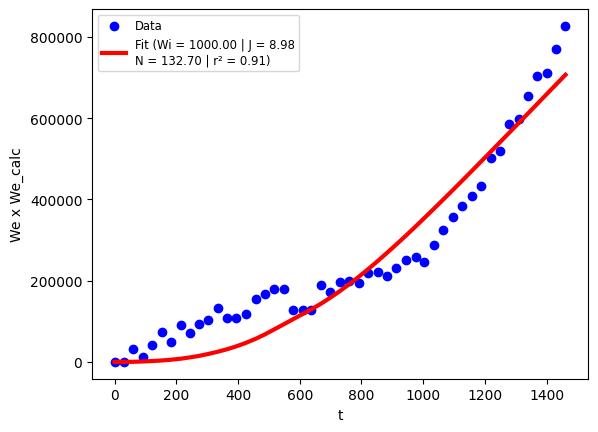

In [15]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m):
    N = x[0]  # N é constante
    Wi = x[1]  # Wei é constante
    J = x[2]  # J é constante
    Wei = (cf+cw)*Wi*p[0]*10**6
    Wen = np.zeros(len(t))
    pa_med = np.zeros(len(t))
    pa_med[0] = p[0]
    for i in range(1,len(t)):
      pa_med[i-1]=p[0]*(1-(Wen[i-1]/Wei))
      Wen[i]=Wen[i-1]+(Wei/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
    We_EBM = F - (N*10**6) * (Eo + m * Eg + Efw)
    return np.sum((We_EBM - Wen) ** 2)

# Chute inicial para N, Wi e J
x0 = np.array([130] + [100] + [10])

# Limites para N, Wi e J
bounds = [(10, 1000)] + [(10, 1000)] + [(1, 100)]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m), bounds=bounds)

N_est = result.x[0]
Wi_est = result.x[1]
J_est = result.x[2]

print(f"Estimativa de N: {N_est:0.2f}")
print(f"Estimativa de Wi: {Wi_est:0.2f}")
print(f"Estimativas de J: {J_est:0.2f}")

Wei_est = (cf+cw)*Wi_est*p[0]*10**6
# print(Wei_est)
Wen = np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
for i in range(1,len(t)):
  pa_med[i-1] = p[0]*(1-(Wen[i-1]/Wei_est))
  Wen[i] = Wen[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
pa_med[len(t)-1] = p[0]*(1-(Wen[len(t)-1]/Wei_est))
We_EBM = F - (N_est*10**6) * (Eo + m * Eg + Efw)
print(pa_med)

r2_2 = r2_score(We_EBM, Wen)
print(r2_2)

plt.scatter(t, We_EBM, label="Data", color="blue")
plt.plot(t, Wen, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("We x We_calc")
plt.show()

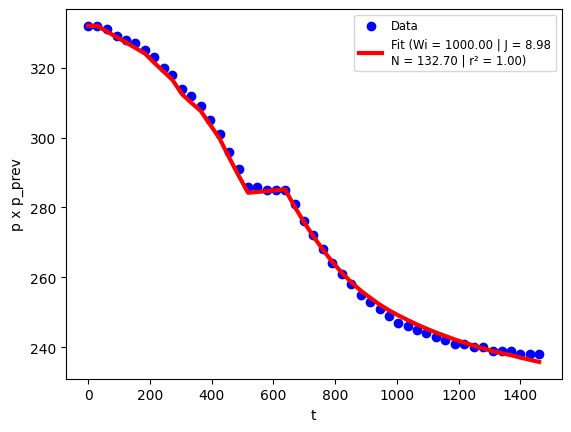

In [16]:
## Previsao de pressao

p_prev=np.zeros(len(t))
we_aquif=np.zeros(len(t))
ppa_med=np.zeros(len(t))
we_ebm=np.zeros(len(t))

for i in range(len(t)):
  if i == 0:
    p_prev[i]=p[0]
    we_aquif[i]=0
    ppa_med[i]=p[0]
    we_ebm[i]=0
  else:
    # Função objetivo
    def obj_f(x, m, N, Wei, J):
      pn = x[0]  # pressao prevista

      ## Aquifero
      ppa_med[i-1]=p[0]*(1-(we_aquif[i-1]/Wei))
      we_aquif[i]=we_aquif[i-1]+(Wei/p[0])*(ppa_med[i-1]-pn)*(1-np.exp(-J*p[0]*dt[i]/Wei))

      ## EBM
      if pn < pb:
        bop = 1.40676 * pn - 1.04229
        rsp = 0.4655 * pn + 15.0114
      else:
        bop = bob - co * (pn - pb)
        rsp = Rsi
        bgp = 1.40676*pn**(-1.04229)
        fp=npp[i]*(bop+(rp[i]-rsp)*bgp)+(wp[i]-winj[i])*Bw
        eop=bop-bo[0]+(Rsi-rsp)*bgp
        egp=bo[0]*((bgp/bg[0])-1)
        efwp=(1+m)*bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
        we_ebm[i]=fp-N*(eop+m*egp+efwp)*10**6

      return (we_ebm[i] - we_aquif[i]) ** 2

    x0 = [p_prev[i-1]]
    result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))
    p_prev[i]=result.x[0]

r2_2 = r2_score(p, p_prev)
# print(r2_2)

plt.scatter(t, p, label="Data", color="blue")
plt.plot(t, p_prev, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.show()